<a href="https://colab.research.google.com/github/gerritgr/nextaid_bdprocess/blob/main/BD_Process_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx 
import os, glob, time
import pandas as pd
import numpy as np
import pickle, random
import seaborn as sns

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import tensorflow as tf


In [ ]:
os.system('mkdir weights')

256

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [ ]:
!sudo apt-get install gifsicle && pip install pygifsicle

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gifsicle is already the newest version (1.91-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def multi_density(x, mean_1=-2, mean_2=2, sd_1=0.3, sd_2=0.6):
  from scipy.stats import norm
  return 0.5 * norm.pdf(x, loc=mean_1, scale=sd_1) + 0.5 * norm.pdf(x, loc=mean_2, scale=sd_2) 

In [ ]:

x_vec = np.linspace(-5, 5, 100)
y_vec = np.array([multi_density(x) for x in x_vec])
y_vec_Z = np.sum(y_vec)
y_vec = y_vec/y_vec_Z

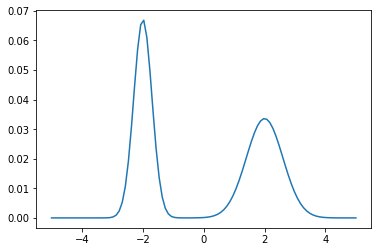

In [ ]:
plt.plot(x_vec, y_vec)

In [ ]:
prob_matrix = np.zeros([100,100]) 
stay = 0.0
mean_direction = 1/2.0
for i in range(100):
  if i == 0:
    prob_matrix[i,i] = stay * 2
    prob_matrix[i,i+1] = 1.0-(stay*2)
  elif i == 99:
    prob_matrix[i,i] = stay*2
    prob_matrix[i,i-1] = 1.0-(stay*2)
  elif i == 50:
    prob_matrix[i,i] = stay
    prob_matrix[i,i-1] = (1.0-stay)*0.5
    prob_matrix[i,i+1] = (1.0-stay)*0.5
  elif i < 50:
    prob_matrix[i,i] = stay
    prob_matrix[i,i-1] = (1.0-stay)*(1.0-mean_direction)
    prob_matrix[i,i+1] = (1.0-stay)*(mean_direction)
  elif i > 50: 
    prob_matrix[i,i] = stay
    prob_matrix[i,i-1] = (1.0-stay)*(mean_direction)
    prob_matrix[i,i+1] = (1.0-stay)*(1.0-mean_direction)
  else:
    assert(False)
#prob_matrix = prob_matrix.transpose()
prob_matrix

np.sum(prob_matrix, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
prob_matrix.shape

(100, 100)

In [ ]:
pi = y_vec.reshape(1,100) # 1,100

In [ ]:
TIME_SCALE = 1000
sol = np.zeros([TIME_SCALE,100])
for i in range(TIME_SCALE):
  # (n,k),(k,m)->(n,m)     n=100, k=100, m=1
  sol[i,:] = pi.flatten()
  pi = np.matmul(pi, prob_matrix)  # pi prob matrix

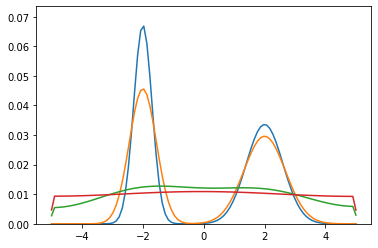

In [ ]:
plt.plot(x_vec, sol[0,:])
plt.plot(x_vec, sol[10,:])
plt.plot(x_vec, sol[300,:])
plt.plot(x_vec, sol[TIME_SCALE-1,:])
_ = plt.ylim((0.0,np.max(sol)*1.1))

### Gif

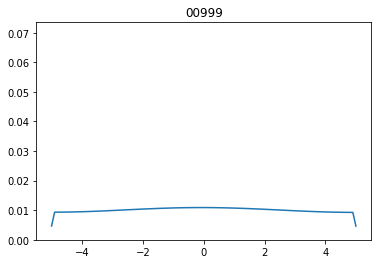

In [ ]:
os.system('mkdir output_kernel1')
for i in range(sol.shape[0]):
  if i == 0 or i == range(sol.shape[0])[-1] or i%20 == 0:
    plt.clf()
    plt.plot(x_vec, sol[i,:].flatten())
    plt.ylim((0.0,np.max(sol)*1.1)) 
    plt.title((str(i).zfill(5)))
    plt.savefig('output_kernel1/step_{}.png'.format(str(i).zfill(5)))
    #if i > 500:
    #  break

In [ ]:
import imageio
with imageio.get_writer('kernel1.gif', mode='I', fps=5.0) as writer:
    for filename in sorted(glob.glob('output_kernel1/step*.png')):
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
time.sleep(1)
from pygifsicle import optimize
optimize("kernel1.gif")

# Sampling

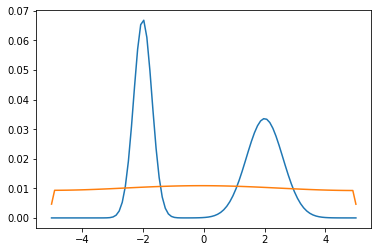

In [ ]:
plt.plot(x_vec, sol[0,:])
plt.plot(x_vec, sol[-1,:])

### Sample Forward

In [ ]:
def gen_forward_trajectory():
  init_point = np.random.choice(list(range(100)), size=1, p=y_vec/np.sum(y_vec))
  init_v = int(init_point[0])
  trajetory = np.zeros(TIME_SCALE, dtype=int)
  trajetory[0] = init_v
  for i in range(TIME_SCALE-1):
    current_pos = trajetory[i]
    prob_go_to_left = 0.0
    try:
      prob_go_to_left = prob_matrix[current_pos, current_pos-1]
    except:
      pass
    prob_go_to_right = 0.0
    try:
      prob_go_to_right = prob_matrix[current_pos, current_pos+1]
    except:
      pass
    prob_stay = prob_matrix[current_pos, current_pos]
    next_state_prob = np.array([prob_go_to_left, prob_stay, prob_go_to_right])
    next_state_prob = next_state_prob / np.sum(next_state_prob)
    next_state = np.random.choice([-1,0,1], size=1, p=next_state_prob) +  trajetory[i]
    trajetory[i+1] = next_state
  return trajetory

In [ ]:
trajetories_forward = [gen_forward_trajectory() for _ in range(100)]

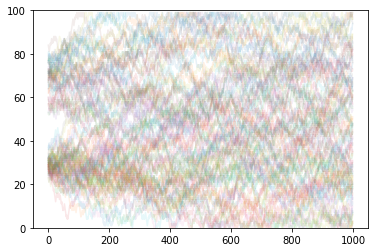

In [ ]:
for trajetory in trajetories_forward:
  plt.plot(trajetory, alpha=0.1)
z = plt.ylim((0, 100))

In [ ]:
def gen_trainloader(traj_num = 1000, mini_batch_size = 100):
  trajetories_forward = [gen_forward_trajectory() for _ in range(traj_num)]
  sample_data = list()
  for traj in trajetories_forward:
    for i in range(len(traj)-1):
      input = torch.tensor([traj[i+1],i+1], dtype=torch.float, device=DEVICE)
      prediction = torch.zeros(3, dtype=torch.float, device=DEVICE)
      if traj[i+1] ==  traj[i]:
        prediction[1] = 1.0
      elif traj[i+1] ==  traj[i]+1:
        prediction[0] = 1.0
      elif traj[i+1] ==  traj[i]-1:
        prediction[2] = 1.0
      sample = (input, prediction)
      sample_data.append(sample) 
  train_data = DataLoader(sample_data, batch_size=mini_batch_size, shuffle=True) 
  return train_data


### Sample Backward

In [ ]:
def gen_trajectory():
  init_point = np.random.choice(list(range(100)), size=1, p=[1/100.0 for _ in range(100)])
  init_v = int(init_point[0])
  
  trajetory = np.zeros(TIME_SCALE, dtype=int)
  trajetory[0] = init_v
  for i in range(TIME_SCALE-1):
    current_pos = trajetory[i]

    prob_go_to_left = 0.0
    if current_pos != 0:
      prob_go_to_left = sol[TIME_SCALE-i-2, current_pos-1] * prob_matrix[current_pos-1, current_pos] # prior to be in left state at t-1 * prob to go from left state to current state

    prob_go_to_right = 0.0
    if current_pos != 99:
      prob_go_to_right = sol[TIME_SCALE-i-2, current_pos+1] * prob_matrix[current_pos+1, current_pos] # prior to be in left state at t-1 * prob to go from left state to current state

    prob_form_same =  sol[TIME_SCALE-i-2, current_pos] * prob_matrix[current_pos, current_pos]

    next_state_prob = np.array([prob_go_to_left, prob_form_same, prob_go_to_right])
    next_state_prob = next_state_prob / np.sum(next_state_prob)
    next_state = np.random.choice([-1,0,1], size=1, p=next_state_prob) +  trajetory[i]
    trajetory[i+1] = next_state
  return trajetory



In [ ]:
trajetories = [gen_trajectory() for _ in range(100)]

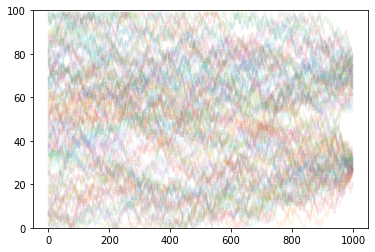

In [ ]:
for trajetory in trajetories:
  plt.plot(trajetory, alpha=0.1)
z = plt.ylim((0, 100))

In [ ]:
os.system('mkdir output_back1')
for i in range(TIME_SCALE):
  if i == 0 or i == range(TIME_SCALE)[-1] or i % 10 == 0:
    plt.clf()
    sns.histplot([t[i] for t in trajetories], bins=20)
    #plt.plot(x_vec, sol[i,:].flatten())
    #plt.ylim((0.0,np.max(sol)*1.1)) 
    plt.xlim((0, 100))
    #plt.ylim((0, 0.12))
    plt.title((str(i).zfill(5)))
    plt.savefig('output_back1/step_{}.png'.format(str(i).zfill(5)))
    plt.close()

In [ ]:
import imageio
with imageio.get_writer('back1.gif', mode='I', fps=5.0) as writer:
    for filename in sorted(glob.glob('output_back1/step*.png')):
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
time.sleep(1)
from pygifsicle import optimize
optimize("back1.gif")

## Training

In [ ]:
class GuidanceNet(torch.nn.Module):
  def __init__(self, input_size=2, hidden_size=100, layer_number=15, out_size=3, softmax_out = True):
    super(GuidanceNet, self).__init__()
    self.input_size = input_size
    self.hidden_size  = hidden_size
    self.softmax = nn.Softmax(dim=1)
    self.softmax_out = softmax_out

    layers = []
    layers.append(nn.Linear(input_size, hidden_size))
    layers.append(nn.ReLU()) # or make leaky
    for i in range(layer_number):
      layers.append(nn.Linear(hidden_size, hidden_size))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=0.05))
    layers.append(nn.Linear(hidden_size, out_size))
    self.mlp = nn.Sequential(*layers)

  def forward(self, x):
    x = self.mlp(x)
    if not self.softmax_out:
      return x
    x = self.softmax(x)
    return x

net = GuidanceNet()

### Eval Model

In [ ]:

def gen_trajectory_learned():
    init_point = np.random.choice(list(range(100)), size=1, p=[1/100.0 for _ in range(100)])
    init_v = int(init_point[0])

    trajetory = np.zeros(TIME_SCALE, dtype=int)
    trajetory[0] = init_v
    for i in range(TIME_SCALE-1):
        current_pos = trajetory[i]
        input = torch.tensor([current_pos, TIME_SCALE-i-1], dtype=torch.float, device=DEVICE)
        input = input.reshape(1, -1)
        prediction = model(input).flatten().detach().cpu().numpy()
        assert(np.sum(prediction) > 0.9999 and np.sum(prediction) < 1.0001)

        next_state = np.random.choice([-1,0,1], size=1, p=prediction) +  trajetory[i]
        trajetory[i+1] = next_state
        trajetory[i+1] = max(0,trajetory[i+1])
        trajetory[i+1] = min(99,trajetory[i+1])
    return trajetory

def eval_model(model, epoch):
    model.eval()
    
    # map
    pred_map = np.zeros([TIME_SCALE,100])
    for t in range(TIME_SCALE):
        for pos in range(100):
            input = torch.tensor([pos, t], dtype=torch.float, device=DEVICE)
            input = input.reshape(1, -1) # batch format
            net_output = model(input)
            x = float(net_output[0][0] - net_output[0][2])
            pred_map[t, pos] = 1/(1+np.exp(-x))  #cut off at 0
    pred_map[0][0] = 1.0
    pred_map[0][1] = 0.0
    plt.clf()
    plt.imshow(pred_map, cmap='seismic', interpolation="nearest")
    plt.colorbar()
    plt.savefig('map_{}.png'.format(100000+epoch), dpi=300)
    
    
    #trajs 
    plt.clf()
    traj_learned = [gen_trajectory_learned() for _ in range(30)]
    for trajetory in traj_learned:
        plt.plot(trajetory, alpha=0.1)
    z = plt.ylim((0, 100))
    plt.savefig('trajs_learned_{}.png'.format(100000+epoch), dpi=300)
    plt.clf()
    
    #final
    traj_learned = [gen_trajectory_learned() for _ in range(500)]
    for pos in [0,-1,int(TIME_SCALE/2)]:
        final_state = [traj[pos] for traj in traj_learned]
        sns.displot(final_state, kde=True)
        z = plt.xlim((0, 100))
        plt.savefig('trajs_learned_final_{}_{}.png'.format(100000+epoch, pos), dpi=300)
        plt.clf()
    

## Training Procedure

In [ ]:
def train(train_loader, criterion, optimizer, model):
  model.train()
  loss_list = list()
  pbar = tf.keras.utils.Progbar(target=len(train_loader))
  for idx, (input, target) in enumerate(train_loader):
    optimizer.zero_grad() 
    input_noise = input + torch.randn(input.shape, device=DEVICE) #* 2.0
    prediction = model(input_noise)
    loss = criterion(prediction, target)
    loss.backward()  
    optimizer.step()   
    loss = float(loss)
    loss_list.append(loss)
    pbar.update(idx, values=[("loss",loss)])
  return np.mean(loss_list)


In [ ]:
def loss_fn(prediction, target):
  loss_value = prediction*target
  loss_value = torch.sum(loss_value, dim=1)
  loss_value = -torch.log(loss_value+0.000000001) 
  loss_value = torch.mean(loss_value) # or sum for actual negative LL
  return loss_value

In [ ]:
def load_model():
  filepath = sorted(list(glob.glob('weights/training_state*')))
  if len(filepath) == 0:
    return None
  state = torch.load(filepath[-1], map_location=DEVICE)
  print('loaded model ',state['epoch'])
  return state

def write_model(epoch, model, optimizer):
  if epoch == 0:
    return
  state = {'optimizer': optimizer.state_dict(), 'epoch': epoch+1, 'state_dict': model.state_dict()} 
  torch.save(state, 'weights/training_state.pickle')


In [ ]:
# setup
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/molecules')

criterion = loss_fn
#criterion =  nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
model = GuidanceNet()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_list = list()

BATCH_SIZE = 100
TRAJ_NUM = 10
EPOCH_NUM = 50

train_loader = None

# load state
state = load_model()
epoch_start = 0
if state is not None:
  optimizer.load_state_dict(state['optimizer'])
  model.load_state_dict(state['state_dict'])
  epoch_start = state['epoch']


# training loop
for epoch_i in range(EPOCH_NUM):
  if epoch_i < epoch_start:
    continue
  if epoch_i % 50 == 0 or epoch_i == EPOCH_NUM-1: 
    train_loader = gen_trainloader(traj_num = TRAJ_NUM, mini_batch_size = BATCH_SIZE)
  loss = train(train_loader, criterion, optimizer, model)
  loss_list.append(loss)
  print("   Epoch {}/{} finished.".format(epoch_i+1, EPOCH_NUM))
  writer.add_scalar("Loss/train", loss, epoch_i)
  writer.close()
  if epoch_i % 20 == 0:
    eval_model(model, epoch_i)
    write_model(epoch_i, model, optimizer)

print('done')

 93/100 [==========================>...] - ETA: 0s - loss: 0.6932   Epoch 50/50 finished.
done


<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir runs